# Machine Learning Foundation

## Course 3, Part a: Logistic Regression LAB

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [11]:
import os, seaborn as sns, pandas as pd, numpy as np
from colorsetup import colors, palette
#os.chdir('data')
sns.set_palette(palette)

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [12]:
### BEGIN SOLUTION
filepath = 'Human_Activity_Recognition_Using_Smartphones_Data.csv'
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [13]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [14]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [15]:
## - #1 doesn't inlude last column
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [16]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [17]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)
### END SOLUTION

5778     0
10272    5
9047     2
8102     4
5032     4
Name: Activity, dtype: int32

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [19]:
### BEGIN SOLUTION
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

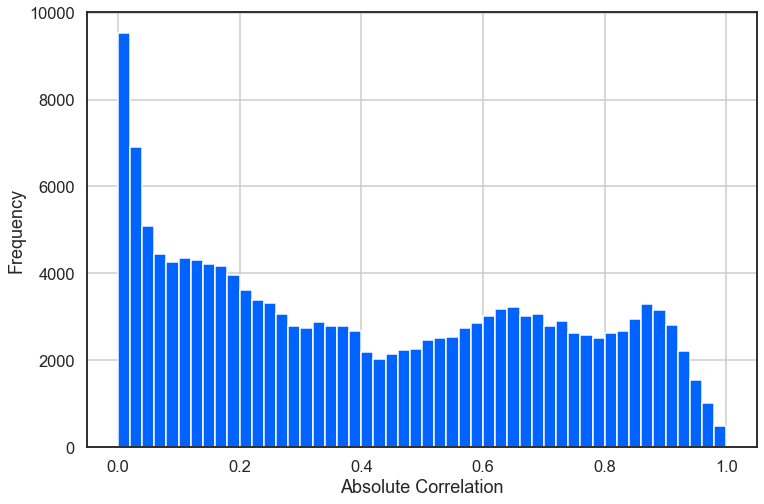

In [21]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [22]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')
### END SOLUTION

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [23]:
### BEGIN SOLUTION
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
#Only 1 set of train and split state
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

#As the strat_shuf_split is a generator value, next will output values as an array
train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [24]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [25]:
y_test.value_counts(normalize=True)
### END SOLUTION

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [26]:
### BEGIN SOLUTION
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
#liblinear is a way to optimise when using 1 vs rest
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [27]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [28]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)
### END SOLUTION

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [29]:
### BEGIN SOLUTION
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
207  0.086239  0.303737 -0.041841 -0.098602  0.069948 -0.896924  0.042537   
419 -0.001539  0.197548  0.234874  0.237327  0.122582  0.064808 -0.506159   
8    0.008111 -0.168286 -0.154104 -0.004435 -0.501346  0.201388 -0.085753   
106 -0.141034  0.320384 -0.184481 -0.166064 -0.654796 -0.029494 -1.375354   
427 -0.035257 -0.261391 -0.100652  0.538774 -0.610537  0.158648  0.000000   
428 -0.041810 -0.086041 -0.051703  0.093832 -0.449934  0.491318 -0.070759   
80   0.033614  0.014859 -0.235214 -0.088628 -0.174788 -0.422457  0.000000   
221  0.086316  0.495130 -0.400590  0.317846  0.238147 -0.092742  0.197245   
191  0.086576 -0.182147 -0.013348 -0.138202 -0.067885 -0.204142  0.947979   
554 -0.061156 -0.059108  0.012841  0.034941 -0.272584  0.112674 -0.346993   

                                                             l2            \
            1         2         3         4         5         0         1   
207  0.000000  0.000000  0.000000  0.200450 -2.614437  0.158578  2.191782   
419  0.090445  0.229192  0.000000  0.167368  0.156332 -0.023849  0.474375   
8    0.000000  0.000000  0.000000 -0.958621  0.000000  0.040126 -0.656479   
106  0.195754 -0.374274  0.000000 -3.229404  0.000000 -0.283655  3.174491   
427  0.000000  0.000000  0.569258 -0.233566  0.139409 -0.052727 -0.808687   
428  0.000000  0.000000  0.000000 -0.681339  1.199803 -0.058257 -0.026872   
80   0.000000  0.000000  0.000000 -0.798502 -1.315051  0.057374 -0.504457   
221  0.445529 -0.526607  0.000000  0.308993 -0.009177  0.234339  0.611665   
191  0.000000  0.000000  0.000000 -0.920368 -2.651668  0.171295 -2.337816   
554  0.167972  0.000000  0.000000 -0.329483  0.391501 -0.179723  0.641248   

                                             
            2         3         4         5  
207 -0.178349  0.001756  0.230769 -1.991248  
419  0.292961  0.700173  0.453892  0.202176  
8   -0.237888 -0.030789 -1.777014  0.451337  
106 -0.743555 -0.670256 -2.434006  0.018805  
427 -0.057749  1.318891 -2.202146  0.253835  
428 -0.026263  0.185397 -1.680775  0.945857  
80  -0.403262 -0.512240 -0.841955 -1.250932  
221 -0.466113  0.599562  1.164279 -0.362591  
191  0.265796 -0.152551 -0.696419 -0.439907  
554 -0.104723 -0.093653 -0.947500  0.306963

Prepare six separate plots for each of the multi-class coefficients.

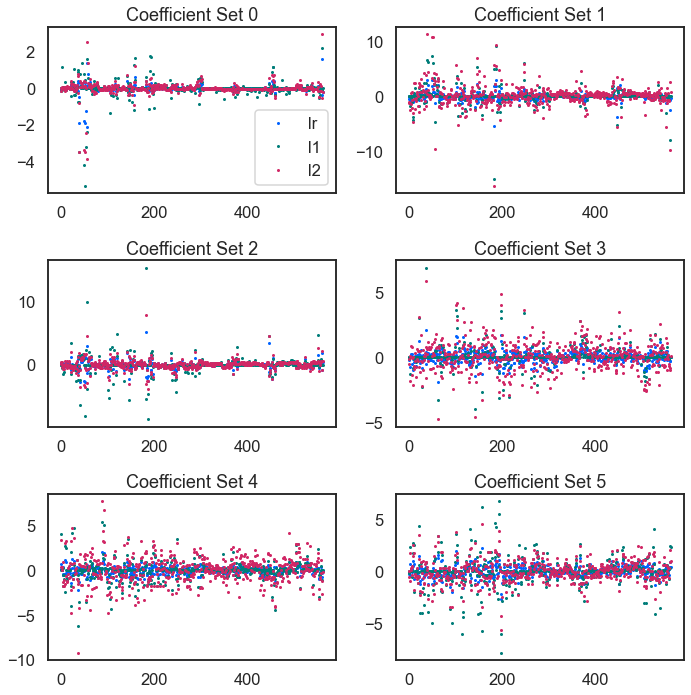

In [30]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    #xs means access individual values
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()
### END SOLUTION

## Question 6

* Predict and store the class for each model.
* Store the probability for the predicted class for each model. 

In [31]:
### BEGIN SOLUTION
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [32]:
y_prob.head()
### END SOLUTION

,lr,l1,l2
0,0.998939,0.998974,0.999757
1,0.988125,0.999530,0.999998
2,0.987576,0.995517,0.999899
3,0.981381,0.999156,0.994337
4,0.998277,0.999922,0.999997


## Question 7

For each model, calculate the following error metrics: 

* Accuracy
* Precision
* Recall
* F-score
* Confusion Matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [33]:
### BEGIN SOLUTION
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [34]:
metrics
### END SOLUTION

,lr,l1,l2
precision,0.984144,0.983833,0.984148
recall,0.984142,0.983819,0.984142
fscore,0.984143,0.983817,0.984143
accuracy,0.984142,0.983819,0.984142
auc,0.990384,0.990148,0.990352


## Question 8

Display or plot the confusion matrix for each model.

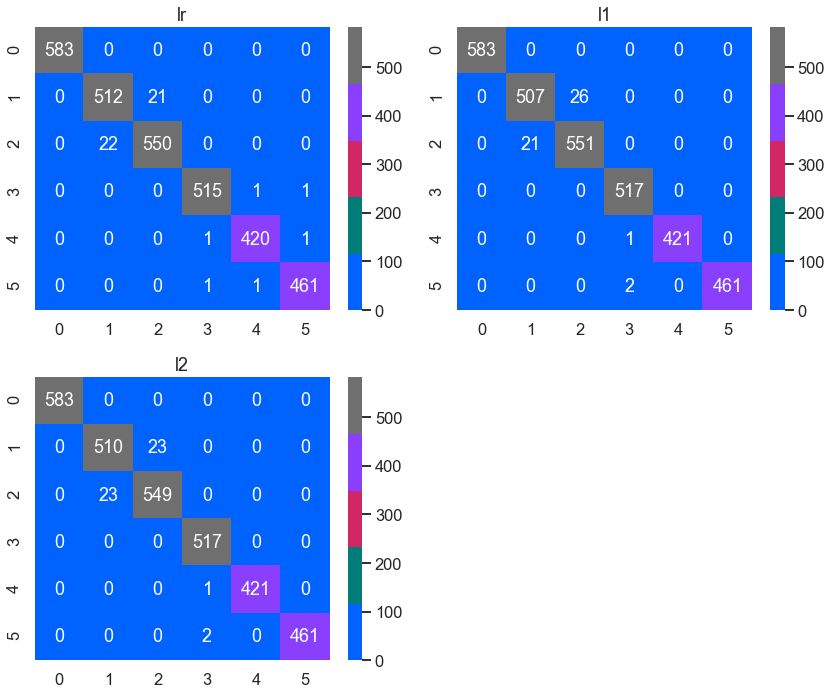

In [35]:
### BEGIN SOLUTION
fig, axList = plt.subplots(nrows=2, ncols=2)
#flatten allows us to loop
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap=colors);
    ax.set(title=lab);
    
plt.tight_layout()
### END SOLUTION

---
### Machine Learning Foundation (C) 2020 IBM Corporation